In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
import torch
import timm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
from math import ceil
from tqdm.notebook import tqdm
import wandb
from torch_lr_finder import LRFinder
from utils import EarlyStopping
import utils
import plotly.express as px
import robust_loss_pytorch 

In [2]:
from scipy import ndimage
from pickle import load

In [3]:
run = wandb.init(project='HyperView-initial', reinit=True)
# wandb.init(mode="disabled") # in case of testing code

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jcharyton (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### Paths definition

In [4]:
train_data_directory = r'../../train_data'
test_data_directory = r'../../test_data'
saved_models_directory = r'../../saved_models'
submissions_directory = r'../../submissions'

### Load mean and std values of training dataset

In [5]:
means_stds_arrays = np.load(os.path.join(
    train_data_directory, 'means_stds_values_training_data.npz'))
means = np.array(means_stds_arrays['means'])
stds = np.array(means_stds_arrays['stds'])

### Load scalers for parameters

In [6]:
parameters_scalers = dict()
parameters_scalers['P'] = load((open(os.path.join(train_data_directory, 'standard_scaler_P.pkl'), 'rb')))
parameters_scalers['K'] = load((open(os.path.join(train_data_directory, 'standard_scaler_K.pkl'), 'rb')))
parameters_scalers['Mg'] = load((open(os.path.join(train_data_directory, 'standard_scaler_Mg.pkl'), 'rb')))
parameters_scalers['pH'] = load((open(os.path.join(train_data_directory, 'standard_scaler_pH.pkl'), 'rb')))

In [7]:
parameters_scalers['P'].mean_

array([70.30265589])

### Dataset definition

In [8]:
class HyperViewDataset(Dataset):
    def __init__(self, gt_file, img_dir, transform=True, means=None, stds=None, train_transforms=False, parameters_scalers=None):
        self.img_dir = img_dir
        if gt_file is not None:
            self.gt = pd.read_csv(gt_file)[['sample_index', 'P', 'K', 'Mg', 'pH']]
        else:
            self.gt = None
        self.transform = transform  # whether to perform transformation of input data
        # whether to perform transformations like on training data
        self.train_transforms = train_transforms

        if self.train_transforms:
            self.training_transforms_composition = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.4), transforms.RandomVerticalFlip(p=0.4)])

        self.means = means  # mean values for every band used to normalize data
        self.stds = stds  # std values for every band used to normalize data

        self.img_files = np.array(
            sorted(
                glob(os.path.join(img_dir, "*.npz")),
                key=lambda x: int(os.path.basename(x).replace(".npz", "")),
            )
        )

        if parameters_scalers is not None:
            self.scaler_P = parameters_scalers['P']
            self.scaler_K = parameters_scalers['K']
            self.scaler_Mg = parameters_scalers['Mg']
            self.scaler_pH = parameters_scalers['pH']
        else:
            self.scaler_P = None
            self.scaler_K = None
            self.scaler_Mg = None
            self.scaler_pH = None

    def pad_to_minimum_size(self, min_size, image):
        # pads numpy array to defined in `min_size` minimum size of array (w, h)
        c, h, w = image.shape
        h_diff = (min_size - h)/2
        w_diff = (min_size - w)/2

        if not h_diff.is_integer():
            h_pad1 = int(h_diff - 0.5)
            h_pad2 = int(h_diff + 0.5)
        else:
            h_pad1 = h_pad2 = int(h_diff)

        if not w_diff.is_integer():
            w_pad1 = int(w_diff - 0.5)
            w_pad2 = int(w_diff + 0.5)
        else:
            w_pad1 = w_pad2 = int(w_diff)

        # check if any padding is bigger than zero
        if h_pad1+h_pad2+w_pad1+h_pad2 == 0:
            return image
        else:
            return transforms.functional.pad(image, (w_pad1, h_pad1, w_pad2, h_pad2), fill=0)

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        # load hyperspectral image to array
        img_arr = np.ma.MaskedArray(**np.load(self.img_files[idx]))
        img_tensor = torch.as_tensor(img_arr.data, dtype=torch.float)
        # Inverting mask is necessary due to masking method in numpy
        img_tensor_mask = ~torch.as_tensor(img_arr.mask)
        img_masked_tensor = torch.mul(img_tensor, img_tensor_mask)

        if self.transform:
            img_masked_tensor_transformed = transforms.functional.normalize(
                img_masked_tensor, mean=self.means.tolist(), std=self.stds.tolist())
            img_masked_tensor_transformed = self.pad_to_minimum_size(
                300, img_masked_tensor_transformed)
            if self.train_transforms:
                img_masked_tensor_transformed = self.training_transforms_composition(
                    img_masked_tensor_transformed)
            img_result_tensor = img_masked_tensor_transformed
        else:
            img_result_tensor = img_masked_tensor
        # load labels
        if self.gt is not None:
            P_gt = self.gt.loc[idx, 'P']
            K_gt = self.gt.loc[idx, 'K']
            Mg_gt = self.gt.loc[idx, 'Mg']
            pH_gt = self.gt.loc[idx, 'pH']
            sample_index = self.gt.loc[idx, 'sample_index']
            
            if self.scaler_P is not None:
                assert self.scaler_K is not None
                assert self.scaler_Mg is not None
                assert self.scaler_pH is not None
                
                P_gt = self.scaler_P.transform(np.array(P_gt).reshape(1, -1))[0][0]
                K_gt = self.scaler_K.transform(np.array(K_gt).reshape(1, -1))[0][0]
                Mg_gt = self.scaler_Mg.transform(np.array(Mg_gt).reshape(1, -1))[0][0]
                pH_gt = self.scaler_pH.transform(np.array(pH_gt).reshape(1, -1))[0][0]
                

            sample = {'image': img_result_tensor, 'P': P_gt,
                      'K': K_gt, 'Mg': Mg_gt, 'pH': pH_gt, 'sample_index': sample_index}
        else:
            sample = {'image': img_result_tensor}

        return sample

In [9]:
train_data_whole = HyperViewDataset(os.path.join(train_data_directory, 'train_gt.csv'), os.path.join(
    train_data_directory, 'train_data'), True, means, stds, train_transforms=True, parameters_scalers=parameters_scalers)

In [10]:
train_dataset, validation_dataset = random_split(train_data_whole, [1000, 732], generator=torch.Generator().manual_seed(22))
# train_dataset = torch.utils.data.Subset(train_data_whole, list(range(0, 1400)))
# validation_dataset = torch.utils.data.Subset(train_data_whole, list(range(1400, len(train_data_whole))))

### Model Definition

In [11]:
import torchvision
from torchvision import datasets, models, transforms

In [12]:
class ResNetCNN(nn.Module):
    def __init__(self, pretrained):
        super().__init__()
        self.resnet_model = models.resnet50(pretrained=False)

        self.resnet_model.conv1 = nn.Conv2d(150, 64, kernel_size=(
            7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet_model.fc = nn.Linear(
            in_features=2048, out_features=1, bias=True)

    def forward(self, x):
        x = self.resnet_model(x)
#         return {'P': x[0], 'K': x[1], 'Mg': x[2], 'pH': x[3]}
        return x

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [14]:
BATCH_SIZE = 12
EPOCHS = 300

In [15]:
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4, shuffle=True)
validation_dataloader = DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4, shuffle=True)

In [16]:
model = ResNetCNN(pretrained=False).to(device)

#### Load pretrained weights

##### Download weights for resnet50

In [16]:
url = "https://download.pytorch.org/models/resnet50-0676ba61.pth"
state = torch.utils.model_zoo.load_url(url)

In [17]:
state_resnet = {f'resnet_model.{k}': v for k, v in state.items()}

In [18]:
# Adapt last layer (FC) to 1 class output
state_resnet['resnet_model.fc.weight'] = state_resnet['resnet_model.fc.weight'][:1, :]
state_resnet['resnet_model.fc.bias'] = state_resnet['resnet_model.fc.bias'][:1]

In [19]:
# Adapt conv1 layer to 150 input channels
conv1_weight = state_resnet['resnet_model.conv1.weight']
conv1_dtype = conv1_weight.dtype
conv1_weight = conv1_weight.float()
repeat = int(ceil(150 / 3))
conv1_weight = conv1_weight.repeat(1, repeat, 1, 1)[:, :150, :, :] # copy first 3 channels repeat-times
conv1_weight *= (3 / float(150))
conv1_weight = conv1_weight.to(conv1_dtype)
state_resnet['resnet_model.conv1.weight'] = conv1_weight

In [20]:
model.load_state_dict(state_resnet)

NameError: name 'model' is not defined

### Overfitting on single batch of data

In [43]:
loss_func = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
           num_dims = 1, float_dtype=torch.float64, device=device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [23]:
train_data_single_batch = next(iter(train_dataloader))

In [32]:
train_data_single_batch['image'][0].shape

torch.Size([150, 300, 300])

In [33]:
train_data_single_batch['image'].to(device, dtype=torch.float).shape

torch.Size([12, 150, 300, 300])

In [34]:
output = model(train_data_single_batch['image'].to(device, dtype=torch.float))

In [35]:
output.shape

torch.Size([12, 1])

In [36]:
output

tensor([[-2.2047],
        [ 1.0042],
        [-1.8225],
        [-1.3878],
        [-1.5235],
        [-1.2069],
        [-0.0674],
        [-0.1617],
        [ 0.0609],
        [-1.6381],
        [-0.5389],
        [-1.4088]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [37]:
stacked_gt = train_data_single_batch['P'].unsqueeze(dim=0).permute(1, 0).to(device)
stacked_gt

tensor([[-0.3154],
        [-1.4138],
        [-0.6612],
        [-1.1121],
        [-0.9256],
        [ 0.3322],
        [-0.7053],
        [-0.2442],
        [-0.2747],
        [ 0.8610],
        [-0.6341],
        [-0.6408]], device='cuda:0', dtype=torch.float64)

In [44]:
torch.mean(loss_func.lossfun((output - stacked_gt)))

tensor(1.7293, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)

#### Sprawdzenie czy inwersja skalowania działa właściwie

In [56]:
gt_df = pd.read_csv(os.path.join(train_data_directory, 'train_gt.csv'))[
    ['sample_index', 'P', 'K', 'Mg', 'pH']]

In [57]:
train_data_single_batch['sample_index']

tensor([1015,  927, 1359,  327, 1289, 1253,  961, 1579,  340,  347,  760,  883])

In [58]:
gt_df.loc[train_data_single_batch['sample_index'], 'P'].values.reshape(-1, 1)

array([[ 55.2],
       [155. ],
       [ 83.7],
       [ 67.2],
       [ 54.7],
       [ 25.2],
       [ 54.4],
       [ 45. ],
       [100. ],
       [133. ],
       [ 56.9],
       [ 61. ]])

In [59]:
scaler = getattr(train_dataset.dataset, f'scaler_P')
scaler

StandardScaler()

In [60]:
scaler.inverse_transform(stacked_gt.cpu())

array([[ 55.2],
       [155. ],
       [ 83.7],
       [ 67.2],
       [ 54.7],
       [ 25.2],
       [ 54.4],
       [ 45. ],
       [100. ],
       [133. ],
       [ 56.9],
       [ 61. ]])

In [61]:
scaler.inverse_transform(stacked_gt.cpu()) == gt_df.loc[train_data_single_batch['sample_index'], 'P'].values.reshape(-1, 1)

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

#### Właściwa pętla overfit

In [46]:
img_data_device = train_data_single_batch['image'].to(
    device, dtype=torch.float)
stacked_gt_device = train_data_single_batch['P'].unsqueeze(dim=0).permute(1, 0).to(device, dtype=torch.float64)
scaler = getattr(train_dataset.dataset, f'scaler_P')

model = ResNetCNN(False).to(device)
# load pretrained weights
model.load_state_dict(state_resnet)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.02)
loss_func = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
           num_dims = 1, float_dtype=torch.float64, device=device).lossfun
model.train()

for epoch in range(301):

    output = model(img_data_device)
    loss = torch.mean(loss_func((output - stacked_gt_device)))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    output_cpu = output.detach().cpu().numpy()
    stacked_gt_cpu = stacked_gt_device.cpu().numpy()
    
    output_cpu_inversed = scaler.inverse_transform(output_cpu)
    stacked_gt_cpu_inversed = scaler.inverse_transform(stacked_gt_cpu)

    # Calculate MSE for each class
    mse_inversed = np.mean((stacked_gt_cpu_inversed - output_cpu_inversed) ** 2, axis=0)
    mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)

    if epoch % 10 == 0:
        print(f'epoch: {epoch}, loss: {loss.data.cpu().numpy()}, MSE: {mse}, MSE from unscaled values: {mse_inversed}')

epoch: 0, loss: 1.7293316217540533, MSE: [1.74480688], MSE from unscaled values: [1518.03383596]
epoch: 10, loss: 1.54004348281298, MSE: [0.90590281], MSE from unscaled values: [788.16238731]
epoch: 20, loss: 1.4063154480631728, MSE: [0.57303695], MSE from unscaled values: [498.55918876]
epoch: 30, loss: 1.288003236801419, MSE: [0.23926751], MSE from unscaled values: [208.16983796]
epoch: 40, loss: 1.3024274712303578, MSE: [0.27199256], MSE from unscaled values: [236.64161755]
epoch: 50, loss: 1.2860238098203898, MSE: [0.23685146], MSE from unscaled values: [206.0677875]
epoch: 60, loss: 1.2900069567968324, MSE: [0.23999418], MSE from unscaled values: [208.80205258]
epoch: 70, loss: 1.2777229876901184, MSE: [0.217555], MSE from unscaled values: [189.27930731]
epoch: 80, loss: 1.2693781279482614, MSE: [0.19237888], MSE from unscaled values: [167.37533278]
epoch: 90, loss: 1.2630333409562438, MSE: [0.18016826], MSE from unscaled values: [156.75173545]
epoch: 100, loss: 1.2602711101562005

### Training Definition

In [20]:
parameter = 'pH'

In [21]:
save_name = "checkpoint_state_dict_ResNet50_19_05_2022_Single_Parameter_Scaled_PretrainedModel_AdaptiveLoss_{}".format(parameter)
save_name

'checkpoint_state_dict_ResNet50_19_05_2022_Single_Parameter_Scaled_PretrainedModel_AdaptiveLoss_pH'

In [22]:
model_name = save_name+'.pth'

In [23]:
# save subsets indices to text files
np.array(train_dataset.indices).tofile(os.path.join(saved_models_directory, 'DataSubsets_indices', save_name+'_train_indices.txt'), sep='|')
np.array(validation_dataset.indices).tofile(os.path.join(saved_models_directory, 'DataSubsets_indices', save_name+'_validation_indices.txt'), sep='|')

In [24]:
model = ResNetCNN(False).to(device)
# load pretrained weights
model.load_state_dict(state_resnet)

<All keys matched successfully>

In [25]:
wandb.watch(model, log="None", log_freq=20)

[]

In [26]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.02)

In [27]:
loss_func = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
           num_dims = 1, float_dtype=torch.float, device=device).lossfun

#### Find LR

In [89]:
from torch_lr_finder.lr_finder import TrainDataLoaderIter

In [90]:
class CustomTrainIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        return (torch.as_tensor(batch_data['image'], dtype=torch.float),
                torch.as_tensor(batch_data['P'].unsqueeze(dim=0).permute(1, 0), dtype=torch.float))

In [91]:
lr_finder = LRFinder(model, optimizer, loss_func, device=device)
lr_finder.range_test(CustomTrainIter(train_dataloader),
                     start_lr=0.00001, end_lr=100, num_iter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 2.06E-01


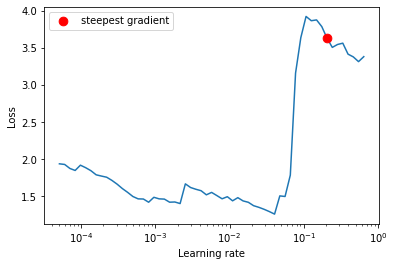

In [92]:
lr_finder.plot()
lr_finder.reset()

In [93]:
2.06E-01

0.206

### Training

In [28]:
patience_scheduler_overfit = 8
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min',
                                                       factor=0.6, patience=patience_scheduler_overfit,
                                                       threshold=0.0001, threshold_mode='abs')

In [29]:
early_stopping = utils.EarlyStopping(patience=(2*patience_scheduler_overfit)+3, verbose=True,
                                     path=os.path.join(saved_models_directory, 'checkpoint_state_dict.pth'))

#### Logging training informations for W&B

In [30]:
config = wandb.config
config.model = 'resnet50'
config.optimizer = 'AdamW'
config.loss_function = 'robust_loss_pytorch.adaptive.AdaptiveLossFunction'
config.learning_rate_start = optimizer.param_groups[0]["lr"]
# config.momentum = optimizer.param_groups[0]["momentum"]
config.momentum = None
config.weight_decay = optimizer.param_groups[0]["weight_decay"]
config.scheduler = 'ReduceLROnPlateau'
config.scheduler_factor = 0.6
config.scheduler_patience = patience_scheduler_overfit
config.scheduler_threshold = 0.0001
config.batch_size = BATCH_SIZE
config.notes = 'ResNet50 Parameter {} SCALED Training split:1000, Validation: 732. Scaled predicted variable. Model pretrained on Imagenet'.format(parameter)
config.parameter = parameter

In [31]:
previous_epochs = 0  # how many epochs have been done previously if resuming

In [32]:
scaler = getattr(train_dataset.dataset, f'scaler_{parameter}')

for epoch in range(previous_epochs, EPOCHS+previous_epochs):
    # TRAINING Part
    model.train()
    train_loss = []
    mse_train_list = []
    mse_inversed_train_list = []

    bar = tqdm(train_dataloader, position=0, leave=False,
               desc=f'epoch {epoch} training data')
    i = 0
    for train_data in bar:  # for each training step
        i += 1
        img_data_device = train_data['image'].to(device, dtype=torch.float)
#         stacked_gt_device = torch.stack((train_data['P'], train_data['K'], train_data['Mg'], train_data['pH'])).transpose(
#             0, 1).to(device, dtype=torch.float)
        stacked_gt_device = train_data[parameter].unsqueeze(dim=0).permute(1, 0).to(device, dtype=torch.float)

        output = model(img_data_device)

        loss = torch.mean(loss_func((output - stacked_gt_device)))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss)

        output_cpu = output.detach().cpu().numpy()
        stacked_gt_cpu = stacked_gt_device.cpu().numpy()
        
        output_cpu_inversed = scaler.inverse_transform(output_cpu)
        stacked_gt_cpu_inversed = scaler.inverse_transform(stacked_gt_cpu)

        # Calculate MSE for each class
        mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
        mse_inversed = np.mean((stacked_gt_cpu_inversed - output_cpu_inversed) ** 2, axis=0)
        mse_train_list.append(mse)
        mse_inversed_train_list.append(mse_inversed)
        

        if i % 10 == 0:  # log every 10 batches
            train_log_dict = dict()
            train_log_dict['batch_number'] = i
            train_log_dict['epoch'] = epoch
            train_log_dict['train_batch_loss'] = loss
            train_log_dict['train_batch_MSE_{}'.format(parameter)] = mse[0]
            wandb.log(train_log_dict)

    avg_train_loss = torch.stack(train_loss).mean().item()
    avg_train_mse = torch.as_tensor(
        np.array(mse_train_list)).mean(axis=0).numpy().tolist()
    avg_train_mse_inversed = torch.as_tensor(
        np.array(mse_inversed_train_list)).mean(axis=0).numpy().tolist()

    print(
        f'epoch: {epoch}, LR: {optimizer.param_groups[0]["lr"]}, train loss: {avg_train_loss}, train MSE: {avg_train_mse}, train MSE from unscaled values: {avg_train_mse_inversed}')
    wandb.log({'epoch': epoch, 'average_train_loss': avg_train_loss, 'average_train_MSE_{}'.format(parameter): avg_train_mse_inversed[0]})

    # VALIDATION Part
    model.eval()
    val_bar = tqdm(validation_dataloader, position=0,
                   leave=False, desc=f'epoch {epoch} validation data')
    with torch.no_grad():
        val_loss = []
        mse_val_list = []
        mse_inversed_val_list = []
        for val_data in val_bar:
            img_data_device = val_data['image'].to(device, dtype=torch.float)
#             stacked_gt_device = torch.stack((val_data['P'], val_data['K'], val_data['Mg'], val_data['pH'])).transpose(
#                 0, 1).to(device, dtype=torch.float)
            stacked_gt_device =  val_data[parameter].unsqueeze(dim=0).permute(1, 0).to(device, dtype=torch.float)

            output = model(img_data_device)

            loss = torch.mean(loss_func((output - stacked_gt_device)))
            val_loss.append(loss)

            output_cpu = output.detach().cpu().numpy()
            stacked_gt_cpu = stacked_gt_device.cpu().numpy()
            
            output_cpu_inversed = scaler.inverse_transform(output_cpu)
            stacked_gt_cpu_inversed = scaler.inverse_transform(stacked_gt_cpu)

            # Calculate MSE for each class
            mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
            mse_val_list.append(mse)
            mse_inversed = np.mean((stacked_gt_cpu_inversed - output_cpu_inversed) ** 2, axis=0)
            mse_inversed_val_list.append(mse_inversed)


        avg_val_loss = torch.stack(val_loss).mean().item()
        avg_val_mse = torch.as_tensor(
            np.array(mse_val_list)).mean(axis=0).numpy().tolist()
        avg_val_mse_inversed = torch.as_tensor(
            np.array(mse_inversed_val_list)).mean(axis=0).numpy().tolist()

        print(f'epoch: {epoch}, validation loss: {avg_val_loss}, validation MSE: {avg_val_mse}, validation MSE from unscaled values: {avg_val_mse_inversed}')
        # using MSE from inversed values in W&B logger to make it compatible with previous runs in W&B
        wandb.log({'epoch': epoch, 'average_val_loss': avg_val_loss, 'average_validation_MSE_{}'.format(parameter): avg_val_mse_inversed[0]}) 

        scheduler.step(avg_val_loss)
        # early_stopping needs the validation loss to check if it has decresed,
        # and if it has, it will make a checkpoint of the current model
        early_stopping(avg_val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

epoch 0 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 0, LR: 0.02, train loss: 1.7846992015838623, train MSE: [6.963407516479492], train MSE from unscaled values: [0.4715338945388794]


epoch 0 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 0, validation loss: 1.809913158416748, validation MSE: [3.62376070022583], validation MSE from unscaled values: [0.24538654088974]
Validation loss decreased (inf --> 1.809913).  Saving model ...


epoch 1 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 1, LR: 0.02, train loss: 1.5257563591003418, train MSE: [0.9939704537391663], train MSE from unscaled values: [0.06730769574642181]


epoch 1 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 1, validation loss: 2.2677266597747803, validation MSE: [12.49029541015625], validation MSE from unscaled values: [0.8457926511764526]
EarlyStopping counter: 1 out of 19


epoch 2 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 2, LR: 0.02, train loss: 1.5087369680404663, train MSE: [0.9420639276504517], train MSE from unscaled values: [0.06379279494285583]


epoch 2 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 2, validation loss: 1.5760092735290527, validation MSE: [1.218617558479309], validation MSE from unscaled values: [0.08251989632844925]
Validation loss decreased (1.809913 --> 1.576009).  Saving model ...


epoch 3 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 3, LR: 0.02, train loss: 1.5070194005966187, train MSE: [0.9203948974609375], train MSE from unscaled values: [0.062325458973646164]


epoch 3 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 3, validation loss: 1.5182466506958008, validation MSE: [0.9607728719711304], validation MSE from unscaled values: [0.06505969166755676]
Validation loss decreased (1.576009 --> 1.518247).  Saving model ...


epoch 4 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 4, LR: 0.02, train loss: 1.5022509098052979, train MSE: [0.9072041511535645], train MSE from unscaled values: [0.06143223121762276]


epoch 4 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 4, validation loss: 1.5029500722885132, validation MSE: [0.9002938866615295], validation MSE from unscaled values: [0.06096429005265236]
Validation loss decreased (1.518247 --> 1.502950).  Saving model ...


epoch 5 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 5, LR: 0.02, train loss: 1.5014278888702393, train MSE: [0.9076769948005676], train MSE from unscaled values: [0.06146423891186714]


epoch 5 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 5, validation loss: 1.502753734588623, validation MSE: [0.9023726582527161], validation MSE from unscaled values: [0.061105065047740936]
Validation loss decreased (1.502950 --> 1.502754).  Saving model ...


epoch 6 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 6, LR: 0.02, train loss: 1.4999092817306519, train MSE: [0.9026083946228027], train MSE from unscaled values: [0.061121027916669846]


epoch 6 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 6, validation loss: 1.5056822299957275, validation MSE: [0.9071899652481079], validation MSE from unscaled values: [0.061431266367435455]
EarlyStopping counter: 1 out of 19


epoch 7 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 7, LR: 0.02, train loss: 1.4936165809631348, train MSE: [0.8813766241073608], train MSE from unscaled values: [0.05968329310417175]


epoch 7 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 7, validation loss: 1.4977035522460938, validation MSE: [0.8794483542442322], validation MSE from unscaled values: [0.05955272167921066]
Validation loss decreased (1.502754 --> 1.497704).  Saving model ...


epoch 8 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 8, LR: 0.02, train loss: 1.4961493015289307, train MSE: [0.8950692415237427], train MSE from unscaled values: [0.06061050295829773]


epoch 8 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 8, validation loss: 1.8689874410629272, validation MSE: [2.2617385387420654], validation MSE from unscaled values: [0.1531558632850647]
EarlyStopping counter: 1 out of 19


epoch 9 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 9, LR: 0.02, train loss: 1.491952896118164, train MSE: [0.8745629191398621], train MSE from unscaled values: [0.059221893548965454]


epoch 9 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 9, validation loss: 1.5001424551010132, validation MSE: [0.8886402249336243], validation MSE from unscaled values: [0.060175154358148575]
EarlyStopping counter: 2 out of 19


epoch 10 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 10, LR: 0.02, train loss: 1.4897003173828125, train MSE: [0.8757468461990356], train MSE from unscaled values: [0.05930207297205925]


epoch 10 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 10, validation loss: 1.551609992980957, validation MSE: [1.0695171356201172], validation MSE from unscaled values: [0.07242340594530106]
EarlyStopping counter: 3 out of 19


epoch 11 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 11, LR: 0.02, train loss: 1.4922291040420532, train MSE: [0.8821468353271484], train MSE from unscaled values: [0.05973544344305992]


epoch 11 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 11, validation loss: 1.508241891860962, validation MSE: [0.9225567579269409], validation MSE from unscaled values: [0.06247185170650482]
EarlyStopping counter: 4 out of 19


epoch 12 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 12, LR: 0.02, train loss: 1.4883795976638794, train MSE: [0.8648843169212341], train MSE from unscaled values: [0.05856650695204735]


epoch 12 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 12, validation loss: 1.5268661975860596, validation MSE: [0.9838985204696655], validation MSE from unscaled values: [0.06662566214799881]
EarlyStopping counter: 5 out of 19


epoch 13 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 13, LR: 0.02, train loss: 1.4967948198318481, train MSE: [0.8919691443443298], train MSE from unscaled values: [0.0604005828499794]


epoch 13 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 13, validation loss: 1.4969732761383057, validation MSE: [0.8795033097267151], validation MSE from unscaled values: [0.05955643579363823]
Validation loss decreased (1.497704 --> 1.496973).  Saving model ...


epoch 14 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 14, LR: 0.02, train loss: 1.4863938093185425, train MSE: [0.8598582148551941], train MSE from unscaled values: [0.058226149529218674]


epoch 14 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 14, validation loss: 1.5467435121536255, validation MSE: [1.0631762742996216], validation MSE from unscaled values: [0.07199404388666153]
EarlyStopping counter: 1 out of 19


epoch 15 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 15, LR: 0.02, train loss: 1.4829732179641724, train MSE: [0.850440502166748], train MSE from unscaled values: [0.05758842080831528]


epoch 15 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 15, validation loss: 1.498895287513733, validation MSE: [0.8820397853851318], validation MSE from unscaled values: [0.05972820147871971]
EarlyStopping counter: 2 out of 19


epoch 16 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 16, LR: 0.02, train loss: 1.4885903596878052, train MSE: [0.8693397045135498], train MSE from unscaled values: [0.058868199586868286]


epoch 16 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 16, validation loss: 1.8456233739852905, validation MSE: [2.158642530441284], validation MSE from unscaled values: [0.14617465436458588]
EarlyStopping counter: 3 out of 19


epoch 17 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 17, LR: 0.02, train loss: 1.4881329536437988, train MSE: [0.8627870082855225], train MSE from unscaled values: [0.05842448025941849]


epoch 17 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 17, validation loss: 1.4979729652404785, validation MSE: [0.8829507231712341], validation MSE from unscaled values: [0.059789884835481644]
EarlyStopping counter: 4 out of 19


epoch 18 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 18, LR: 0.02, train loss: 1.5144481658935547, train MSE: [0.9608607292175293], train MSE from unscaled values: [0.0650656446814537]


epoch 18 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 18, validation loss: 27.86741065979004, validation MSE: [766.2001953125], validation MSE from unscaled values: [51.88400650024414]
EarlyStopping counter: 5 out of 19


epoch 19 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 19, LR: 0.02, train loss: 1.4991936683654785, train MSE: [0.9004784822463989], train MSE from unscaled values: [0.060976799577474594]


epoch 19 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 19, validation loss: 1.5003929138183594, validation MSE: [0.8924767374992371], validation MSE from unscaled values: [0.06043495237827301]
EarlyStopping counter: 6 out of 19


epoch 20 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 20, LR: 0.02, train loss: 1.491997241973877, train MSE: [0.8804053068161011], train MSE from unscaled values: [0.059617526829242706]


epoch 20 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 20, validation loss: 1.498079776763916, validation MSE: [0.8833192586898804], validation MSE from unscaled values: [0.05981484055519104]
EarlyStopping counter: 7 out of 19


epoch 21 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 21, LR: 0.02, train loss: 1.4867912530899048, train MSE: [0.8618173003196716], train MSE from unscaled values: [0.0583588145673275]


epoch 21 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 21, validation loss: 1.5099300146102905, validation MSE: [0.9269872307777405], validation MSE from unscaled values: [0.06277185678482056]
EarlyStopping counter: 8 out of 19


epoch 22 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 22, LR: 0.02, train loss: 1.491513967514038, train MSE: [0.8770585656166077], train MSE from unscaled values: [0.05939089134335518]


epoch 22 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 22, validation loss: 1.4975062608718872, validation MSE: [0.8791528344154358], validation MSE from unscaled values: [0.05953270569443703]
EarlyStopping counter: 9 out of 19


epoch 23 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 23, LR: 0.012, train loss: 1.4876636266708374, train MSE: [0.8608741164207458], train MSE from unscaled values: [0.05829494446516037]


epoch 23 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 23, validation loss: 1.4944103956222534, validation MSE: [0.8698212504386902], validation MSE from unscaled values: [0.05890081450343132]
Validation loss decreased (1.496973 --> 1.494410).  Saving model ...


epoch 24 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 24, LR: 0.012, train loss: 1.4863420724868774, train MSE: [0.8590209484100342], train MSE from unscaled values: [0.05816945806145668]


epoch 24 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 24, validation loss: 1.496834397315979, validation MSE: [0.8790788054466248], validation MSE from unscaled values: [0.0595276914536953]
EarlyStopping counter: 1 out of 19


epoch 25 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 25, LR: 0.012, train loss: 1.4895437955856323, train MSE: [0.8688466548919678], train MSE from unscaled values: [0.05883481726050377]


epoch 25 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 25, validation loss: 1.4968658685684204, validation MSE: [0.8780173063278198], validation MSE from unscaled values: [0.05945581570267677]
EarlyStopping counter: 2 out of 19


epoch 26 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 26, LR: 0.012, train loss: 1.481131672859192, train MSE: [0.841590404510498], train MSE from unscaled values: [0.05698913708329201]


epoch 26 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 26, validation loss: 1.4963358640670776, validation MSE: [0.8758343458175659], validation MSE from unscaled values: [0.059307992458343506]
EarlyStopping counter: 3 out of 19


epoch 27 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 27, LR: 0.012, train loss: 1.4840108156204224, train MSE: [0.8550038933753967], train MSE from unscaled values: [0.05789743736386299]


epoch 27 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 27, validation loss: 1.4971225261688232, validation MSE: [0.8810192942619324], validation MSE from unscaled values: [0.05965909734368324]
EarlyStopping counter: 4 out of 19


epoch 28 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 28, LR: 0.012, train loss: 1.4910602569580078, train MSE: [0.8734119534492493], train MSE from unscaled values: [0.05914396420121193]


epoch 28 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 28, validation loss: 1.499920129776001, validation MSE: [0.8905268907546997], validation MSE from unscaled values: [0.06030290573835373]
EarlyStopping counter: 5 out of 19


epoch 29 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 29, LR: 0.012, train loss: 1.4879004955291748, train MSE: [0.8640364408493042], train MSE from unscaled values: [0.05850908160209656]


epoch 29 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 29, validation loss: 1.4973009824752808, validation MSE: [0.8797769546508789], validation MSE from unscaled values: [0.059574976563453674]
EarlyStopping counter: 6 out of 19


epoch 30 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 30, LR: 0.012, train loss: 1.487328052520752, train MSE: [0.8614538908004761], train MSE from unscaled values: [0.05833420529961586]


epoch 30 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 30, validation loss: 1.4997665882110596, validation MSE: [0.8904010653495789], validation MSE from unscaled values: [0.06029438599944115]
EarlyStopping counter: 7 out of 19


epoch 31 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 31, LR: 0.012, train loss: 1.4841803312301636, train MSE: [0.8543314933776855], train MSE from unscaled values: [0.05785191059112549]


epoch 31 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 31, validation loss: 1.4965459108352661, validation MSE: [0.8815554976463318], validation MSE from unscaled values: [0.05969541147351265]
EarlyStopping counter: 8 out of 19


epoch 32 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 32, LR: 0.012, train loss: 1.4825555086135864, train MSE: [0.8481152057647705], train MSE from unscaled values: [0.05743096396327019]


epoch 32 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 32, validation loss: 1.4962037801742554, validation MSE: [0.8798044323921204], validation MSE from unscaled values: [0.05957683175802231]
EarlyStopping counter: 9 out of 19


epoch 33 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 33, LR: 0.0072, train loss: 1.4821265935897827, train MSE: [0.848067581653595], train MSE from unscaled values: [0.05742773786187172]


epoch 33 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 33, validation loss: 1.4898194074630737, validation MSE: [0.8600731492042542], validation MSE from unscaled values: [0.05824071541428566]
Validation loss decreased (1.494410 --> 1.489819).  Saving model ...


epoch 34 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 34, LR: 0.0072, train loss: 1.4815644025802612, train MSE: [0.8449367880821228], train MSE from unscaled values: [0.057215724140405655]


epoch 34 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 34, validation loss: 1.4924620389938354, validation MSE: [0.8651020526885986], validation MSE from unscaled values: [0.05858124420046806]
EarlyStopping counter: 1 out of 19


epoch 35 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 35, LR: 0.0072, train loss: 1.4779983758926392, train MSE: [0.8301878571510315], train MSE from unscaled values: [0.056216999888420105]


epoch 35 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 35, validation loss: 1.4951820373535156, validation MSE: [0.876685619354248], validation MSE from unscaled values: [0.059365641325712204]
EarlyStopping counter: 2 out of 19


epoch 36 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 36, LR: 0.0072, train loss: 1.4753015041351318, train MSE: [0.8267003893852234], train MSE from unscaled values: [0.05598084256052971]


epoch 36 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 36, validation loss: 1.9596333503723145, validation MSE: [2.5338118076324463], validation MSE from unscaled values: [0.17157956957817078]
EarlyStopping counter: 3 out of 19


epoch 37 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 37, LR: 0.0072, train loss: 1.4802623987197876, train MSE: [0.8362443447113037], train MSE from unscaled values: [0.05662711337208748]


epoch 37 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 37, validation loss: 1.5012280941009521, validation MSE: [0.8939460515975952], validation MSE from unscaled values: [0.06053444743156433]
EarlyStopping counter: 4 out of 19


epoch 38 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 38, LR: 0.0072, train loss: 1.4779152870178223, train MSE: [0.8314808011054993], train MSE from unscaled values: [0.05630455166101456]


epoch 38 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 38, validation loss: 1.494391679763794, validation MSE: [0.8712986707687378], validation MSE from unscaled values: [0.059000857174396515]
EarlyStopping counter: 5 out of 19


epoch 39 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 39, LR: 0.0072, train loss: 1.480043888092041, train MSE: [0.8366443514823914], train MSE from unscaled values: [0.05665420740842819]


epoch 39 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 39, validation loss: 1.5021777153015137, validation MSE: [0.894259512424469], validation MSE from unscaled values: [0.06055567413568497]
EarlyStopping counter: 6 out of 19


epoch 40 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 40, LR: 0.0072, train loss: 1.4754866361618042, train MSE: [0.8279682993888855], train MSE from unscaled values: [0.056066691875457764]


epoch 40 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 40, validation loss: 1.4923137426376343, validation MSE: [0.8656196594238281], validation MSE from unscaled values: [0.058616288006305695]
EarlyStopping counter: 7 out of 19


epoch 41 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 41, LR: 0.0072, train loss: 1.4764050245285034, train MSE: [0.8309160470962524], train MSE from unscaled values: [0.056266315281391144]


epoch 41 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 41, validation loss: 1.4982903003692627, validation MSE: [0.8829215168952942], validation MSE from unscaled values: [0.05978790670633316]
EarlyStopping counter: 8 out of 19


epoch 42 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 42, LR: 0.0072, train loss: 1.476661205291748, train MSE: [0.8305197358131409], train MSE from unscaled values: [0.05623946711421013]


epoch 42 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 42, validation loss: 1.4909064769744873, validation MSE: [0.8642576932907104], validation MSE from unscaled values: [0.05852406099438667]
EarlyStopping counter: 9 out of 19


epoch 43 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 43, LR: 0.00432, train loss: 1.466996431350708, train MSE: [0.7976593375205994], train MSE from unscaled values: [0.05401429906487465]


epoch 43 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 43, validation loss: 1.4925622940063477, validation MSE: [0.8691813945770264], validation MSE from unscaled values: [0.05885748565196991]
EarlyStopping counter: 10 out of 19


epoch 44 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 44, LR: 0.00432, train loss: 1.4728443622589111, train MSE: [0.8148831129074097], train MSE from unscaled values: [0.055180624127388]


epoch 44 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 44, validation loss: 1.4919263124465942, validation MSE: [0.8620632886886597], validation MSE from unscaled values: [0.05837547034025192]
EarlyStopping counter: 11 out of 19


epoch 45 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 45, LR: 0.00432, train loss: 1.4683483839035034, train MSE: [0.8064078688621521], train MSE from unscaled values: [0.05460670217871666]


epoch 45 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 45, validation loss: 1.4986342191696167, validation MSE: [0.8835129141807556], validation MSE from unscaled values: [0.059827953577041626]
EarlyStopping counter: 12 out of 19


epoch 46 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 46, LR: 0.00432, train loss: 1.4702826738357544, train MSE: [0.8114979863166809], train MSE from unscaled values: [0.054951392114162445]


epoch 46 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 46, validation loss: 1.4980562925338745, validation MSE: [0.8829517960548401], validation MSE from unscaled values: [0.059789955615997314]
EarlyStopping counter: 13 out of 19


epoch 47 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 47, LR: 0.00432, train loss: 1.4666359424591064, train MSE: [0.8027689456939697], train MSE from unscaled values: [0.054360292851924896]


epoch 47 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 47, validation loss: 1.4923772811889648, validation MSE: [0.8642850518226624], validation MSE from unscaled values: [0.0585259310901165]
EarlyStopping counter: 14 out of 19


epoch 48 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 48, LR: 0.00432, train loss: 1.468935489654541, train MSE: [0.8083537220954895], train MSE from unscaled values: [0.05473848059773445]


epoch 48 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 48, validation loss: 1.4911003112792969, validation MSE: [0.8629228472709656], validation MSE from unscaled values: [0.05843367800116539]
EarlyStopping counter: 15 out of 19


epoch 49 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 49, LR: 0.00432, train loss: 1.4651387929916382, train MSE: [0.7938096523284912], train MSE from unscaled values: [0.05375361815094948]


epoch 49 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 49, validation loss: 1.4944065809249878, validation MSE: [0.872218668460846], validation MSE from unscaled values: [0.0590631440281868]
EarlyStopping counter: 16 out of 19


epoch 50 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 50, LR: 0.00432, train loss: 1.4672205448150635, train MSE: [0.8034895062446594], train MSE from unscaled values: [0.054409097880125046]


epoch 50 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 50, validation loss: 1.4930431842803955, validation MSE: [0.8726954460144043], validation MSE from unscaled values: [0.059095438569784164]
EarlyStopping counter: 17 out of 19


epoch 51 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 51, LR: 0.00432, train loss: 1.4688661098480225, train MSE: [0.8062572479248047], train MSE from unscaled values: [0.05459650978446007]


epoch 51 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 51, validation loss: 1.5007357597351074, validation MSE: [0.8903855681419373], validation MSE from unscaled values: [0.060293346643447876]
EarlyStopping counter: 18 out of 19


epoch 52 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 52, LR: 0.002592, train loss: 1.4677969217300415, train MSE: [0.8030450940132141], train MSE from unscaled values: [0.05437900498509407]


epoch 52 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 52, validation loss: 1.497215986251831, validation MSE: [0.8857942819595337], validation MSE from unscaled values: [0.05998244136571884]
EarlyStopping counter: 19 out of 19
Early stopping


#### Saving model state dict and loading

In [33]:
torch.save(model.state_dict(), os.path.join(
    saved_models_directory, model_name+f'_EPOCHS_{epoch}.pth'))

In [34]:
# rename checkpoint.pth
! mv ../../saved_models/checkpoint_state_dict.pth ../../saved_models/checkpoint_state_dict_ResNet50_19_05_2022_Single_Parameter_Scaled_PretrainedModel_AdaptiveLoss_pH.pth

In [35]:
# load saved model
modelLoad = ResNetCNN(False)
modelLoad.load_state_dict(torch.load(os.path.join(
    saved_models_directory, 'checkpoint_state_dict_ResNet50_19_05_2022_Single_Parameter_Scaled_PretrainedModel_AdaptiveLoss_pH.pth')))

<All keys matched successfully>

In [36]:
modelLoad = modelLoad.to(device)